#### This code draws a stacked area graph based on the data from a single domain crawl before postprocessing. Only hyperlinks to URLs (articles/domains) are counted. To count text aliases, the part for processing text aliases could be imported from the postprocessor for a full crawl that Amy wrote.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

#### Below is what a .json file from the domain crawler, an actual sample data, looks like:

In [2]:
with open('./json/0b642bf8-49aa-5f93-896d-e4d1590fa293.json', encoding='utf-8') as json_data:
    data = json.load(json_data) 

data

{'title': 'White House Covid-19 Team Makes Remarks on Vaccine SupplyWhite House Covid-19 Team Makes Remarks on Vaccine Supply',
 'url': 'https://www.nytimes.com/video/us/politics/100000007647327/new-jersey-indoor-dining-capacity-fifty-percent.html',
 'author_metadata': None,
 'date': '',
 'html_content': '<div id="readability-page-1" class="page"><div id="site-content"><div><p aria-live="assertive">new video loaded: <!-- -->White House Covid-19 Team Makes Remarks on Vaccine Supply</p><div><div><div><div aria-labelledby="modal-title" role="region"><header><p>transcript</p></header><div><div><p>transcript</p><h2>White House Covid-19 Team Makes Remarks on Vaccine Supply</h2><h4>Members of the White House coronavirus team discussed the need for more vaccine supply on Wednesday.</h4></div><dl><dt></dt><dd><p>“Today, President Biden will direct Jeff and the Health and Human Services team to procure an additional 100 million doses of the Johnson &amp;amp; Johnson vaccine. This order allows fo

#### We could focus on a different set of sources we are interested in and a different period of times by modifying keys in sources_url & sources_num_of_ref and time_list defined below. The first two dictionaries act as an "input scope". The test data below intend to see how many times Jerusalem Post, Haaretz, and Palestine News Network have been referred by the media/journalists in the input scope over the past three years (2018, 2019, 2020).

In [3]:
# test source list: can be expanded based on the input scope file
# 'Youtube' and 'Facebook' is included here for testing

sources_url = {
    'Youtube': 'youtube.com',
    'Facebook': 'facebook.com',
    'Jerusalem Post': 'jpost.com',
    'Haaretz': 'haaretz.com',
    'Palestine News Network': 'english.pnn.ps'
    }

sources_num_of_ref = {
    'Youtube': {},
    'Facebook': {},
    'Jerusalem Post': {},
    'Haaretz': {},
    'Palestine News Network': {}
    }
    
time_list = [str(i) for i in list(range(2018, 2021))]

In [4]:
def read_json_file(filename, sources_url, sources_num_of_ref, time_interval):
    '''
    Read from a .json file which represents an webpage (usually an article)
    and store the number of sources that are hyperlinked
    by updating sources_num_of_ref (dictionary)
    
    Parameters
    --------
    filename: string
              name of a .json file to read from
    sources_url: dict
                 (Name: URL)
    sources_num_of_ref: dict
                        Name: dict of (Time: Number of references)
    time_interval: string
                   'month' or 'year'
                   
    Return
    --------
    sources_num_of_ref: dict
    '''
    
    with open(filename, encoding='utf-8') as json_data:
        data = json.load(json_data) 
        
        # 1. ths sample data I received do not have 'date' variable filled;
        # the following code is based on the assumption that 'date' is in the format of 'yyyy-mm-dd'
        # 2. since we only crawl one "referring" domain,
        # all external links will be considered "out of scope urls"
        if 'out_of_scope_urls' in data and len(data['date']) is not 0:
            for url in data['out_of_scope_urls']:
                for key, value in sources_url.items():
                    if value in url:
                        if time_interval == "year":
                            if data['date'][:4] in sources_num_of_ref[key]:
                                sources_num_of_ref[key][data['date']] += 1
                            else:
                                sources_num_of_ref[key][data['date']] = 1
                        if time_interval == "month":
                            if data['date'][:7] in sources_num_of_ref[key]:
                                sources_num_of_ref[key][data['date']] += 1
                            else:
                                sources_num_of_ref[key][data['date']] = 1

In [5]:
def read_json_files(path_to_folder, sources_url, sources_num_of_ref, time_interval):
    '''
    read from .json files in the designated folder
    
    Parameters
    --------
    path_to_folder: string
    sources_url: dict
                 (Name: URL)
    sources_num_of_ref: dict
                        Name: dict of (Time: Number of references)
    time_interval: string
                   'month' or 'year'
    '''
    for filename in os.listdir(path_to_folder):
        read_json_file(path_to_folder + '//' + filename, sources_url, sources_num_of_ref, time_interval)

In [6]:
def convert_dict_to_pd_for_stacked_area_chart(sources_num_of_ref):
    '''
    Convert the dictionary format output date into a pandas dataframe
    for easier navigation
    
    Parameters
    --------
    sources_num_of_ref: dict
                        Name: dict of (Time: Number of references)
                   
    Return
    --------
    a pandas dataframe with time points (e.g., 2018, 2019, 2020) as indices and
    area names (e.g., 'Palestine Chronicle', 'Times of Israel', 'Jerusalem Post')
    as column labels
    '''
    
    data_all_area_list = []
    for source, record in sources_num_of_ref.items():
        data_each_area_list = []
        for time in time_list:
            if time in record:
                data_each_area_list.append(record[time])
            else:
                data_each_area_list.append(0)
        data_all_area_list.append(data_each_area_list)

    return pd.DataFrame(list(map(list, zip(*data_all_area_list))), index=time_list,
                        columns=list(sources_num_of_ref.keys())) 

In [7]:
read_json_files('./json', sources_url, sources_num_of_ref, "year")

#### Since the sample data I currently have do not contain publication dates, I made up a toy imaginary sample, which could potentially be acquired if we input adequate data, below to test the visualization part.

In [8]:
sources_num_of_ref = {
    'Jerusalem Post': {'2018':10, '2019':14, '2020':35},
    'Haaretz': {'2018':17, '2019':12, '2020':23},
    'Palestine News Network': {'2018':10, '2019':9, '2020':7}
          }

In [9]:
df = convert_dict_to_pd_for_stacked_area_chart(sources_num_of_ref)

#### Below is how the data behind the stacked area chart looks like:

In [10]:
df

,Jerusalem Post,Haaretz,Palestine News Network
2018,10,17,10
2019,14,12,9
2020,35,23,7


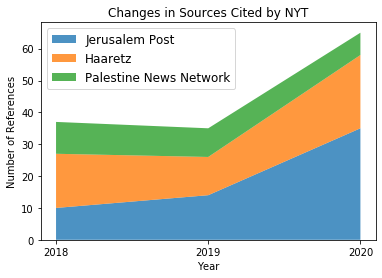

In [13]:
plt.stackplot(time_list,
              df.transpose(),
              labels=list(df.columns),
              alpha=0.8)

plt.legend(loc=2, fontsize='large')
plt.title("Changes in Sources Cited by NYT")
plt.ylabel("Number of References")
plt.xlabel("Year")
plt.show()

#### The data file exported as .csv file below can be used to produce a stacked area graph or graphs of similar types with other libraries/languages/tools.

In [12]:
df.to_csv('data_for_stacked_area_chart.csv')  